# Dimensionality Reduction - Image Data

In [1]:
import numpy as np
from sklearn import datasets, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap, TSNE, MDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import ticker
import time

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, UpSampling2D, Conv2DTranspose, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean

import faiss
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import shortest_path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## MNIST

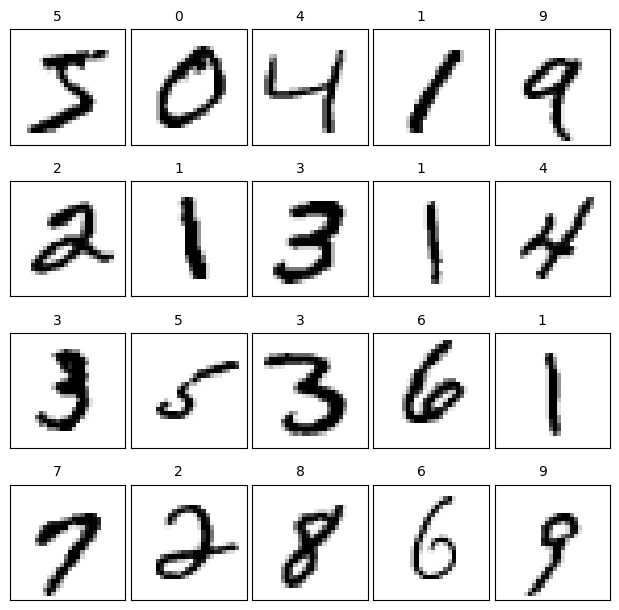

In [2]:
# Load and normalise the fashion mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.

# Visualise 25 samples
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap=plt.cm.binary)
    # label the image with the target value
    ax.text(10, -2.5, str(y_train[i]))

In [3]:
# Reshape the dataset for PCA, Isomap and t-SNE
X_train = x_train.reshape(-1, 784) 
X_test = x_test.reshape(-1, 784)  

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


### PCA

In [4]:
# Standardise data before performing PCA
mnist_scaler = StandardScaler()
x_train_scaled = mnist_scaler.fit_transform(X_train)
x_test_scaled = mnist_scaler.transform(X_test)

In [5]:
# Perform PCA on MNIST dataset
pca_mnist = decomposition.PCA()
pca_mnist.fit(x_train_scaled)
x_train_pca = pca_mnist.transform(x_train_scaled)

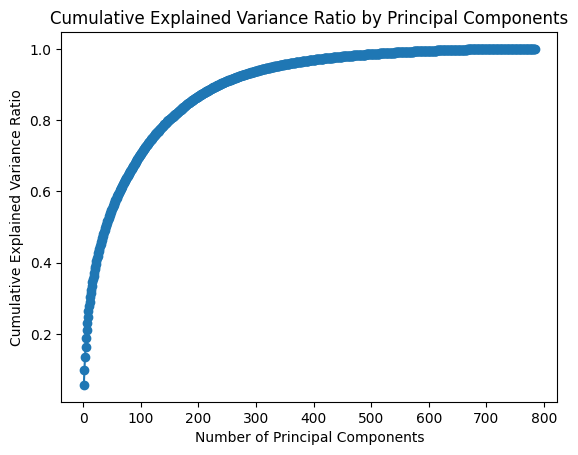

In [6]:
# Examine the cumulative variance explained by principal components
cumulative_variance_ratio = np.cumsum(pca_mnist.explained_variance_ratio_)
x_ticks = list(range(1,len(cumulative_variance_ratio)+1))
plt.plot(x_ticks, cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

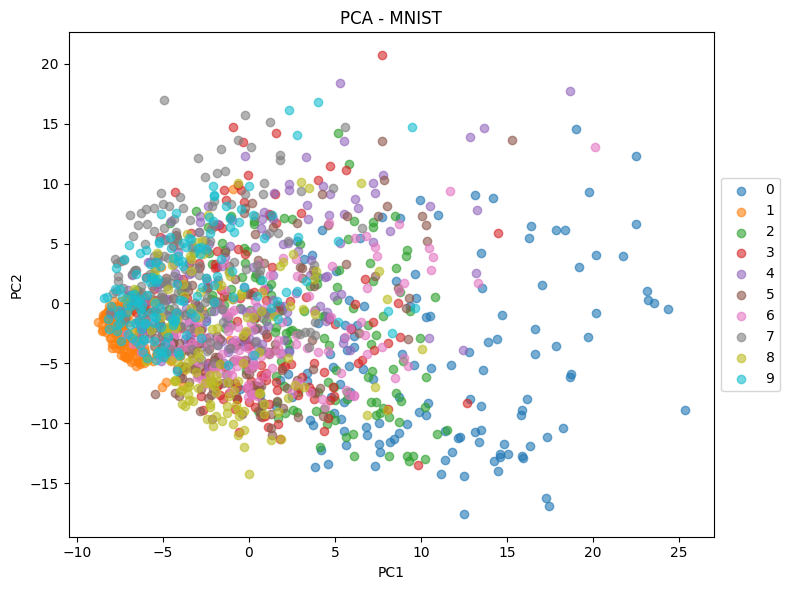

In [7]:
# Define label set and distinct colourmap
unique_labels = set(y_train)


def plot_2d_mnist(x, y, n_data, unique_labels, x_label, y_label, title):
    plt.figure(figsize=(8,6))
    for i in unique_labels:
        plt.scatter(x[:n_data][y[:n_data] == i, 0], 
                    x[:n_data][y[:n_data] == i, 1], 
                    label=i, alpha=0.6)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualise the first two principal components
plot_2d_mnist(x_train_pca, y_train, 1500, unique_labels, 'PC1', 'PC2', 'PCA - MNIST')

### Isomap

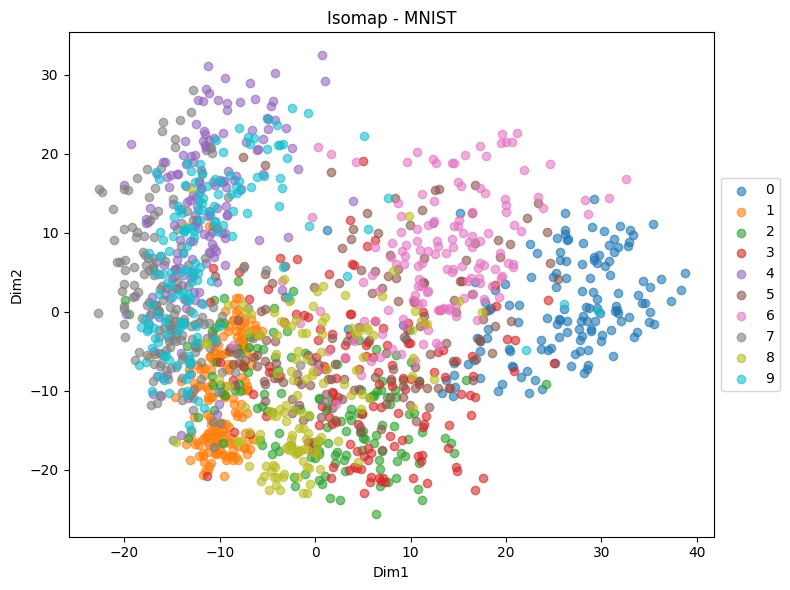

In [8]:
# Reduce the dimensionality of the dataset to two-dimensional using Isomap
isomap_mnist = Isomap(n_components=2, n_neighbors=5) 
# Fit the isomap algorithn using the first 30,000 data points to reduce compute time
x_train_isomap = isomap_mnist.fit_transform(X_train[:10000]) 

# Visualise the 2d representation of the dataset
plot_2d_mnist(x_train_isomap, y_train, 1500, unique_labels, 
               'Dim1', 'Dim2', 'Isomap - MNIST')

### Geodesic distance + MDS

In [ ]:
def compute_geodesic_distances(data, n_neighbors=10, training=False, faiss_index=None, neigh_graph=None):
    
    if training:
        # Use FAISS to find approximate nearest neighbors
        d = data.shape[1]
        faiss_index = faiss.IndexFlatL2(d)
        faiss_index.add(data)
        distances, indices = faiss_index.search(data, n_neighbors)
    
        # Construct sparse neighborhood graph
        n_samples = data.shape[0]
        graph = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(1, n_neighbors):  # start from 1 to skip self-loop
                graph[i, indices[i, j]] = distances[i, j]
                graph[indices[i, j], i] = distances[i, j]
    
        # Compute geodesic distances using the shortest path algorithm
        geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
    else:
        # Use trained FAISS index to find approximate nearest neighbors
        n_train = faiss_index.ntotal
        n_samples = data.shape[0]
        n_total = n_train + n_samples
        distances, indices = faiss_index.search(data, n_neighbors)

        # Construct sparse neighborhood graph
        graph = np.zeros((n_total, n_total))
        graph[:n_train, :n_train] = neigh_graph
        for i in range(n_samples):
            for j in range(1, n_neighbors):  # start from 1 to skip self-loop
                graph[n_train+i, indices[i, j]] = distances[i, j]
                graph[indices[i, j], n_train+i] = distances[i, j]
                
        # Compute geodesic distances using the shortest path algorithm for all data
        geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)

        # Extract the geodesic distances matrix for only new data
        geodesic_distances = geodesic_distances[n_train:, n_train:]
        
    return geodesic_distances, faiss_index, graph

start_time = time.time()
# Compute geodesic distances for mnist dataset (training)
n_neighbors = 10
geodesic_distances, faiss_index, neigh_graph = compute_geodesic_distances(X_train[:30000], n_neighbors=n_neighbors, training=True)
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Time taken to run the function: {elapsed_time} seconds")
# 15000: 117s

print(geodesic_distances.shape)
print(faiss_index.ntotal)

In [9]:
start_time = time.time()
n_neighbors = 5
X = np.concatenate((X_train, X_test), axis=0)
data = X

# Use FAISS to find approximate nearest neighbors
d = data.shape[1]
faiss_index = faiss.IndexFlatL2(d)
faiss_index.add(data)
distances, indices = faiss_index.search(data, n_neighbors)

# Construct sparse neighborhood graph
n_samples = data.shape[0]
graph = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(1, n_neighbors):  # start from 1 to skip self-loop
        graph[i, indices[i, j]] = np.sqrt(distances[i, j])
        graph[indices[i, j], i] = np.sqrt(distances[i, j])

graph = csr_matrix(graph)

# Compute geodesic distances using the shortest path algorithm
geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)

# Calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken to run the function: {elapsed_time} seconds")

Time taken to run the function: 2201.9605391025543 seconds


In [40]:
np.max(geodesic_distances)

102.06534481048584

In [38]:
np.max(isomap_mnist.dist_matrix_)

124.2030927169215

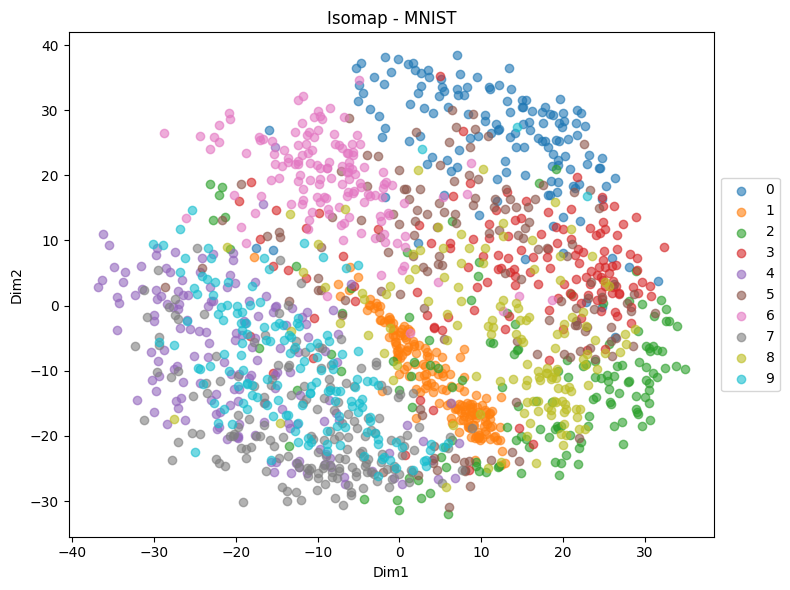

In [14]:
# # Apply MDS on the geodesic distances
# mds = MDS(n_components=2, dissimilarity='precomputed')
# X_mds = mds.fit_transform(geodesic_distances)

# Visualise the 2d representation of the dataset
plot_2d_mnist(X_mds, y_train, 1500, unique_labels, 
              'Dim1', 'Dim2', 'Isomap - MNIST')

In [10]:
# Save the numpy array to a CSV file
np.savetxt("geo_dist_mnist.csv", geodesic_distances, delimiter=",", fmt="%d")

In [9]:
# Load data from CSV file
geodesic_distances = np.loadtxt("geo_dist_mnist.csv", delimiter=",", dtype=np.float32)

# Verify the loaded data
print("Loaded data shape:", geodesic_distances.shape)

Loaded data shape: (60000, 60000)


### t-SNE

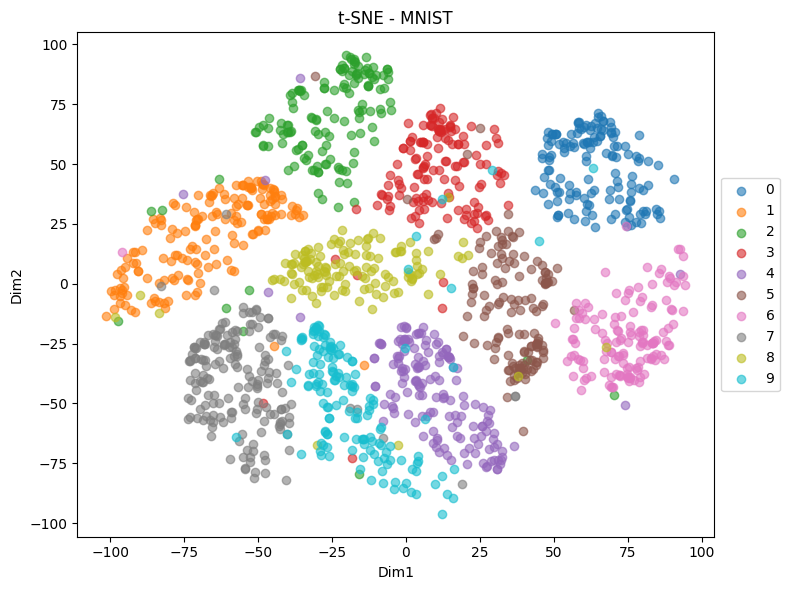

In [10]:
# Reduce the dimensionality of the dataset to two-dimensional using t-SNE
tsne_fmnist = TSNE(n_components=2) 
x_train_tsne = tsne_fmnist.fit_transform(X_train[:30000])

# Visualise the 2d representation of the dataset
plot_2d_mnist(x_train_tsne, y_train, 1500, unique_labels,
               'Dim1', 'Dim2', 't-SNE - MNIST')

### Autoencoder

In [11]:
# Set seed for reproducibility
seed = 7

# Set the dimensions for input and lower embeddings
input_shape = (28, 28, 1)
encoded_dim = 2

def get_cnn_encoder(input_shape, encoded_dim, dataset, seed=5):
    """
    Define the CNN encoder part of a CNN autoencoder.
    
    Parameters:
    input_shape (tuple): Shape of the input data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: CNN encoder model.
    """
    inputs = Input(shape=(input_shape))
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same', 
               kernel_initializer=GlorotUniform(seed=seed))(inputs)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same', 
               kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Dropout(0.2)(x)
    encoded = Dense(encoded_dim, kernel_initializer=GlorotUniform(seed=seed))(x)
    cnn_encoder = Model(inputs, encoded, name=f'{dataset}_cnn_encoder')
    return cnn_encoder

def get_cnn_decoder(input_shape, encoded_dim, dataset, seed=5):
    """
    Define the CNN decoder part of a CNN autoencoder.
    
    Parameters:
    input_shape (tuple): Shape of the output data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: CNN decoder model.
    """
    encoded_inputs = Input(shape=(encoded_dim,))
    x = Dense(64, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(encoded_inputs)
    x = Dense(7*7*64, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Reshape((7, 7, 64))(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same', 
                        kernel_initializer=GlorotUniform(seed=seed))(x)
    decoded = Conv2DTranspose(input_shape[-1], 3, activation='sigmoid', strides=2, padding='same', 
                              kernel_initializer=GlorotUniform(seed=seed))(x)
    cnn_decoder = Model(encoded_inputs, decoded, name=f'{dataset}_cnn_decoder')
    return cnn_decoder
    
def get_cnn_autoencoder(input_shape, encoded_dim, dataset, seed=5):
    """
    Construct the complete CNN autoencoder by combining the CNN encoder and CNN decoder.
    
    Parameters:
    input_shape (tuple): Shape of the input data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: CNN autoencoder model.
    """
    cnn_encoder = get_cnn_encoder(input_shape, encoded_dim, dataset, seed=seed)
    cnn_decoder = get_cnn_decoder(input_shape, encoded_dim, dataset, seed=seed)
    inputs = Input(shape=(input_shape))
    encoded = cnn_encoder(inputs)
    decoded = cnn_decoder(encoded)
    autoencoder = Model(inputs=inputs, outputs=decoded, name=f'{dataset}_cnn_autoencoder')
    return autoencoder

# Build and train the CNN autoencoder for the MNIST dataset
mnist_autoencoder = get_cnn_autoencoder(input_shape, encoded_dim, 'mnist')
mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')

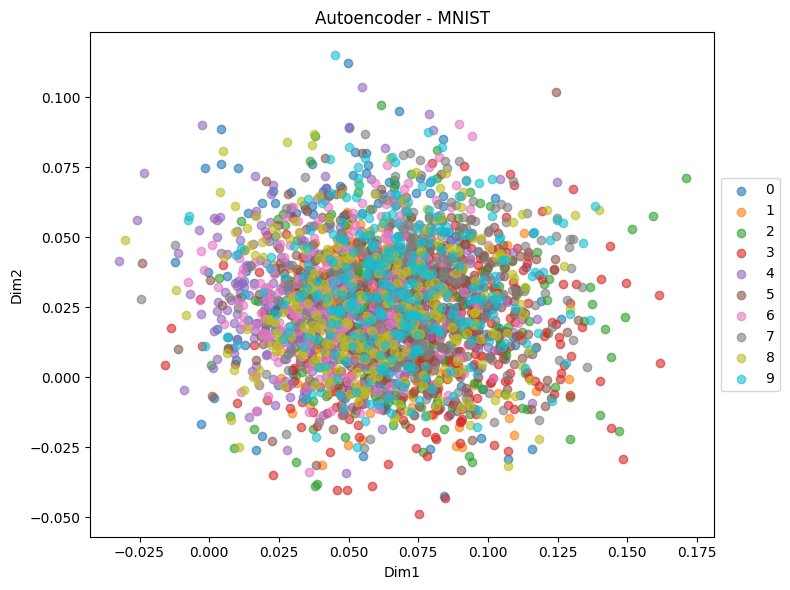

In [12]:
# Compute the encodings after training
untrained_encodings_mnist = mnist_encoder(x_test).numpy()

# Visualise the trained latent encodings
plot_2d_mnist(untrained_encodings_mnist, y_test, 3000, unique_labels, 
               'Dim1', 'Dim2', 'Autoencoder - MNIST')

In [13]:
# Create Dataset objects for train and test sets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))

# Shuffle and batch the datasets
shuffle_buffer_size = 1000
batch_size = 64
train_dataset = train_dataset.shuffle(shuffle_buffer_size, seed).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create an EarlyStopping callback to terminate training if the validation total loss doesn't immprove after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Compile and fit the model
mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

Final Training Loss: 0.0381, Final Validation Loss: 0.0378


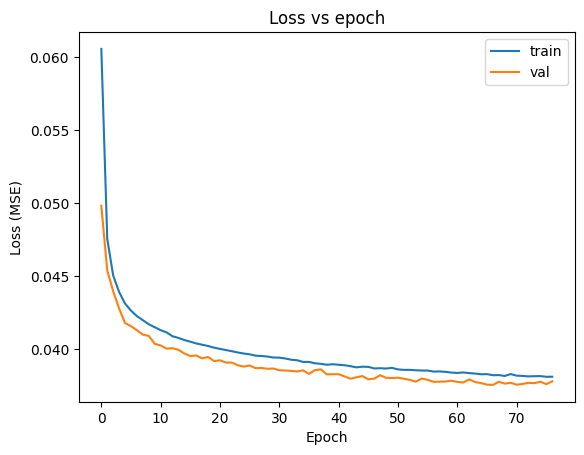

In [14]:
# Print final training and validation loss (MSE)
final_train_loss = history_mnist.history['loss'][-1]
final_val_loss = history_mnist.history['val_loss'][-1]
print(f"Final Training Loss: {final_train_loss:.4f}, Final Validation Loss: {final_val_loss:.4f}")

# Examine the training and validation loss (MSE) over epochs
plt.plot(history_mnist.history['loss'], label='train')
plt.plot(history_mnist.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs epoch")
plt.legend()

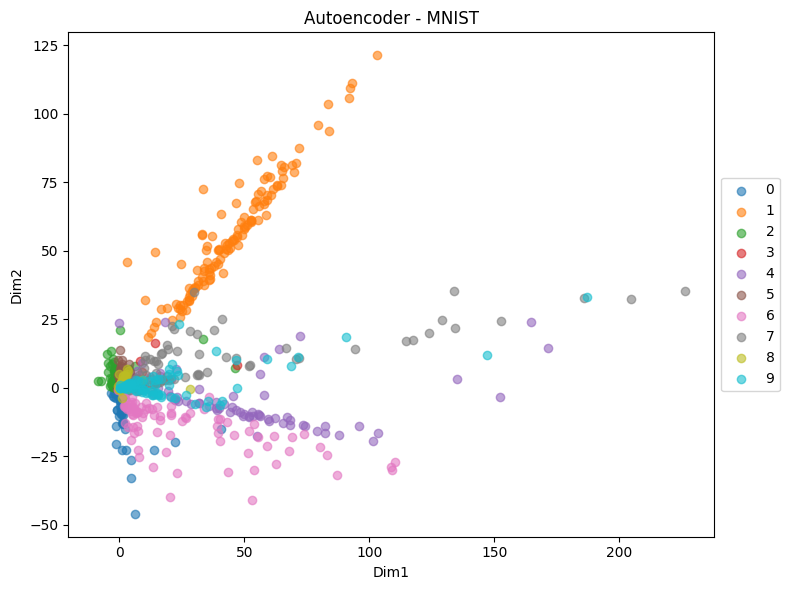

In [15]:
# Compute the encodings after training
trained_encodings_mnist = mnist_encoder(x_test).numpy()

# Visualise the trained latent encodings
plot_2d_mnist(trained_encodings_mnist, y_test, 1000, unique_labels, 
               'Dim1', 'Dim2', 'Autoencoder - MNIST')

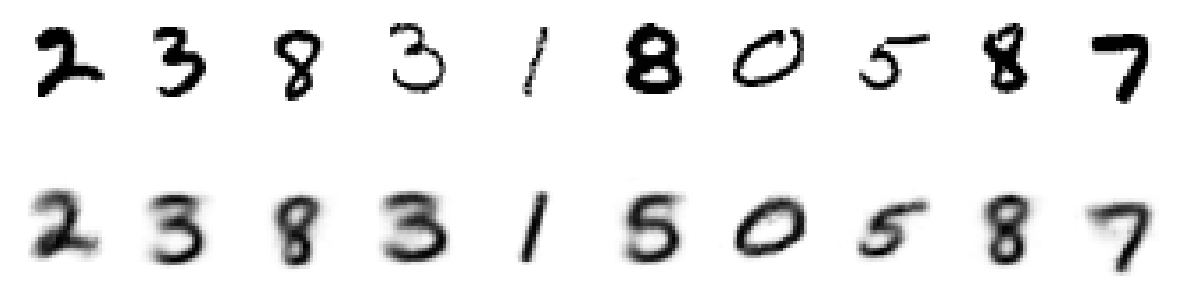

In [16]:
np.random.seed(5)
inx = np.random.choice(x_test.shape[0], 10, replace=False)
reconstructed_mnist_images = mnist_autoencoder(x_test[inx])

f, axs = plt.subplots(2, 10, figsize=(15, 4))
for j in range(10):
    axs[0, j].imshow(x_test[inx][j], cmap='binary')
    axs[1, j].imshow(reconstructed_mnist_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.show()

### GCAE

In [ ]:
class GCAETrainer(Model):
    """
    A trainer class for a GCAE that handles model training and evaluation.
    """
    def __init__(self, dataset, input_dim=(None,None,1), embedding_dim=2, n_neighbors=10, alpha=0.01, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.dataset = dataset
        self.n_neighbors = n_neighbors
        self.gcae = get_cnn_autoencoder(self.input_dim, self.embedding_dim, self.dataset)
        self.encoder = self.gcae.get_layer(f'{self.dataset}_cnn_encoder')
        self.alpha = alpha

        # FAISS index and training data
        self.faiss_index = None
        self.neigh_graph = None
        self.train_geo_dist = None
        self.train_geo_dist_max = None
        self.test_geo_dist = None

        # Define the loss metrics to track and log
        self.total_loss_metric = Mean(name='total_loss')
        self.reconstruction_loss_metric = Mean(name='reconstruction_loss')
        self.geodesic_loss_metric = Mean(name='geodesic_loss')

    @property
    def metrics(self):
        """
        Returns a list of metrics used in training and evaluation.
        """
        return [self.total_loss_metric, self.reconstruction_loss_metric, self.geodesic_loss_metric]

    def compute_geodesic_distances(self, data, training=False):
    
        if training:
            
            # Use FAISS to find approximate nearest neighbors
            d = data.shape[1]
            faiss_index = faiss.IndexFlatL2(d)
            faiss_index.add(data)
            self.faiss_index = faiss_index
            distances, indices = faiss_index.search(data, self.n_neighbors)
        
            # Construct sparse neighborhood graph
            n_samples = data.shape[0]
            graph = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(1, self.n_neighbors):  # start from 1 to skip self-loop
                    graph[i, indices[i, j]] = np.sqrt(distances[i, j])
                    graph[indices[i, j], i] = np.sqrt(distances[i, j])          
            self.neigh_graph = graph
            graph = csr_matrix(graph)
        
            # Compute geodesic distances using the shortest path algorithm
            geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
            geodesic_distances = np.float32(geodesic_distances)
            self.train_geo_dist = geodesic_distances
            self.train_geo_dist_max = np.max(geodesic_distances)
            
        else:

            # Use trained FAISS index to find approximate nearest neighbors
            n_train = self.faiss_index.ntotal
            n_samples = tf.shape(data)[0]
            n_total = n_train + n_samples
            distances, indices = self.faiss_index.search(data, self.n_neighbors)
    
            # Construct sparse neighborhood graph
            graph = np.zeros((n_total, n_total))
            graph[:n_train, :n_train] = self.neigh_graph
            for i in range(n_samples):
                for j in range(1, self.n_neighbors):  # start from 1 to skip self-loop
                    graph[n_train+i, indices[i, j]] = np.sqrt(distances[i, j])
                    graph[indices[i, j], n_train+i] = np.sqrt(distances[i, j])
            graph = csr_matrix(graph)
            
            # Compute geodesic distances using the shortest path algorithm for all data
            geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
    
            # Extract the geodesic distances matrix for only new data
            geodesic_distances = geodesic_distances[n_train:, n_train:]
            geodesic_distances = np.float32(geodesic_distances)
            self.test_geo_dist = geodesic_distances
            
        return geodesic_distances
    
    def compute_geodesic_loss(self, z, geodesic_distances, batch_indices):
        """
        Computes geodesic distance loss.
        """
        # Calculate the pairwise Euclidean distances in the latent space
        z_distances = tf.norm(z[:, tf.newaxis] - z, axis=2)
        # Calculate the geodesic distance loss
        batch_indices_np = batch_indices.numpy()
        geodesic_distances_batch = geodesic_distances[np.ix_(batch_indices_np, batch_indices_np)]
        # geodesic_distances_batch = tf.gather(tf.gather(geodesic_distances, batch_indices, axis=0), batch_indices, axis=1)
        distance_loss = tf.reduce_mean((z_distances - geodesic_distances_batch) ** 2) / self.train_geo_dist_max
        return distance_loss
        
    def _get_losses(self, x, batch_indices, training=False):
        """
        Computes model losses from inputs.
        """
        reconstructions = self.gcae(x, training=training)
        latent = self.encoder(x)
        # Compute the reconstruction loss
        x = tf.expand_dims(x, axis=-1)
        reconstruction_loss = (
            tf.reduce_mean((x - reconstructions) ** 2)
        )
        # Compute the geodesic loss
        if training:
            geodesic_loss = self.compute_geodesic_loss(z=latent, geodesic_distances=self.train_geo_dist, 
                                                       batch_indices=batch_indices)
        else:    
            geodesic_loss = self.compute_geodesic_loss(z=latent, geodesic_distances=self.test_geo_dist, 
                                                       batch_indices=batch_indices)
        # Cmpute the total loss
        total_loss = reconstruction_loss + self.alpha * geodesic_loss
        return total_loss, reconstruction_loss, geodesic_loss

    def train_step(self, data):
        """
        Performs one training step using a single batch of data.
        """
        x, batch_indices = data
        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, geodesic_loss = self._get_losses(x, batch_indices, training=True)
        grads = tape.gradient(total_loss, self.gcae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.gcae.trainable_variables))

        # Update loss metrics
        self.total_loss_metric.update_state(total_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.geodesic_loss_metric.update_state(geodesic_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """
        Evaluates the model using a single batch of data.
        """
        x, batch_indices = data
        total_loss, reconstruction_loss, geodesic_loss = self._get_losses(x, batch_indices, training=False)

        # Update loss metrics
        self.total_loss_metric.update_state(total_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.geodesic_loss_metric.update_state(geodesic_loss)
        return {m.name: m.result() for m in self.metrics}


# Define the gcae trainer
gcae_trainer = GCAETrainer(input_dim=input_shape, embedding_dim=encoded_dim, n_neighbors=5, dataset='mnist')

# Ensure eager execution
tf.config.run_functions_eagerly(True)

# Generate Geodesic distance matrix for train and validation data
train_start_time = time.time()
train_geo_dist = gcae_trainer.compute_geodesic_distances(X_train, training=True)
train_end_time = time.time()
print(f"Time taken to compute geodesic distances for train data: {train_end_time - train_start_time} seconds") # 2286.0790579319 seconds

# Save the numpy array to a CSV file
np.savetxt("mnist_train_geo_dist.csv", gcae_trainer.train_geo_dist, delimiter=",", fmt="%d")

# val_start_time = time.time()
# val_geo_dist = gcae_trainer.compute_geodesic_distances(X_test, training=False)
# val_end_time = time.time()
# print(f"Time taken to compute geodesic distances for val data: {val_end_time - val_start_time} seconds") # 3132.5582678318024 seconds

# # Save the numpy array to a CSV file
# np.savetxt("mnist_test_geo_dist.csv", gcae_trainer.test_geo_dist, delimiter=",", fmt="%d")

In [15]:
# Load data from CSV file
train_geo_dist = np.loadtxt("mnist_train_geo_dist.csv", delimiter=",", dtype=np.float32)
val_geo_dist = np.loadtxt("mnist_test_geo_dist.csv", delimiter=",", dtype=np.float32)

# Verify the loaded data
print("Loaded MNIST train_geo_dist shape:", train_geo_dist.shape)
print("Loaded MNIST val_geo_dist shape:", val_geo_dist.shape)

Loaded MNIST train_geo_dist shape: (60000, 60000)
Loaded MNIST val_geo_dist shape: (10000, 10000)


In [25]:
gcae_trainer.train_geo_dist

array([[ 0., 39., 46., ..., 19., 40., 35.],
       [39.,  0., 45., ..., 38., 35., 39.],
       [46., 45.,  0., ..., 42., 50., 45.],
       ...,
       [19., 38., 42., ...,  0., 39., 36.],
       [40., 35., 50., ..., 39.,  0., 42.],
       [35., 39., 45., ..., 36., 42.,  0.]], dtype=float32)

In [16]:
gcae_trainer.train_geo_dist = train_geo_dist
gcae_trainer.train_geo_dist_max = np.max(train_geo_dist)
gcae_trainer.test_geo_dist = val_geo_dist

Epoch 1/100
1875/1875 [==============================] - 47s 25ms/step - total_loss: 0.0617 - reconstruction_loss: 0.0417 - geodesic_loss: 1.9992 - val_total_loss: 0.0618 - val_reconstruction_loss: 0.0407 - val_geodesic_loss: 2.1103
Epoch 2/100
1875/1875 [==============================] - 46s 25ms/step - total_loss: 0.0615 - reconstruction_loss: 0.0416 - geodesic_loss: 1.9954 - val_total_loss: 0.0618 - val_reconstruction_loss: 0.0407 - val_geodesic_loss: 2.1102
Epoch 3/100
1875/1875 [==============================] - 46s 25ms/step - total_loss: 0.0615 - reconstruction_loss: 0.0415 - geodesic_loss: 1.9943 - val_total_loss: 0.0618 - val_reconstruction_loss: 0.0407 - val_geodesic_loss: 2.1152
Epoch 4/100
1875/1875 [==============================] - 47s 25ms/step - total_loss: 0.0614 - reconstruction_loss: 0.0415 - geodesic_loss: 1.9934 - val_total_loss: 0.0617 - val_reconstruction_loss: 0.0406 - val_geodesic_loss: 2.1104
Epoch 5/100
1875/1875 [==============================] - 46s 25ms/st

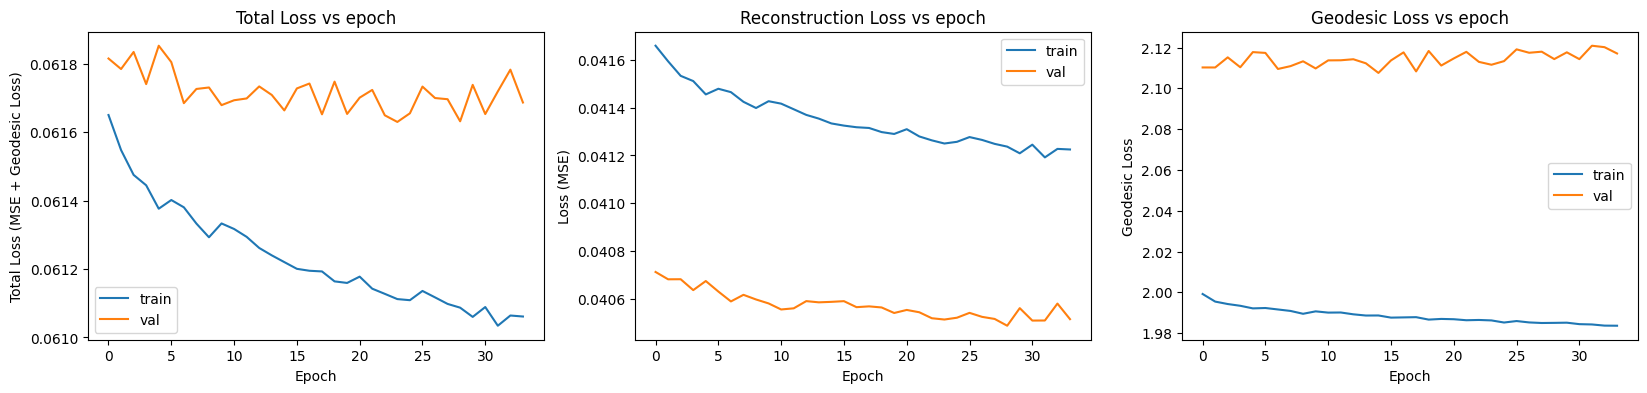

In [24]:
# Convert data to TensorFlow Dataset
batch_size = 32
train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), np.arange(len(x_train))))
train_data = train_data.batch(batch_size)
val_data = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), np.arange(len(x_test))))
val_data = val_data.batch(batch_size)

# Create an EarlyStopping callback to terminate training if the validation total loss doesn't immprove after 10 epochs
early_stopping = EarlyStopping(monitor='val_total_loss', patience=10, mode='min', restore_best_weights=True)

# Train the autoencoder over 100 epochs
gcae_trainer.compile(optimizer='Adam')
history_gc_mnist = gcae_trainer.fit(train_data, validation_data=val_data, epochs=100, callbacks=early_stopping, verbose=1)

# Print final training and validation loss (MSE)
final_train_loss = history_gc_mnist.history['total_loss'][-1]
final_val_loss = history_gc_mnist.history['val_total_loss'][-1]
print(f"Final Training Loss: {final_train_loss:.4f}, Final Validation Loss: {final_val_loss:.4f}")

# Examine the training and validation loss (MSE) over epochs
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(history_gc_mnist.history['total_loss'], label='train')
plt.plot(history_gc_mnist.history['val_total_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Total Loss (MSE + Geodesic Loss)")
plt.title("Total Loss vs epoch")
plt.legend()

plt.subplot(1,3,2)
plt.plot(history_gc_mnist.history['reconstruction_loss'], label='train')
plt.plot(history_gc_mnist.history['val_reconstruction_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Reconstruction Loss vs epoch")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history_gc_mnist.history['geodesic_loss'], label='train')
plt.plot(history_gc_mnist.history['val_geodesic_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Geodesic Loss")
plt.title("Geodesic Loss vs epoch")
plt.legend()
plt.show()

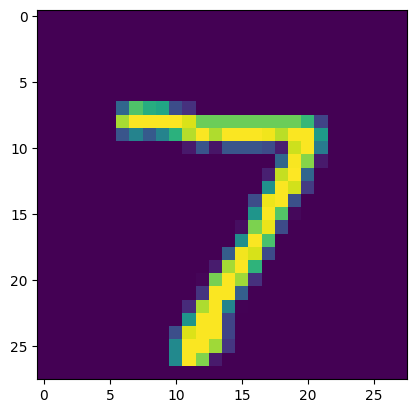

In [22]:
for x, idx in val_data.take(1): 
    plt.imshow(x[0])
    # plt.imshow(x[1])

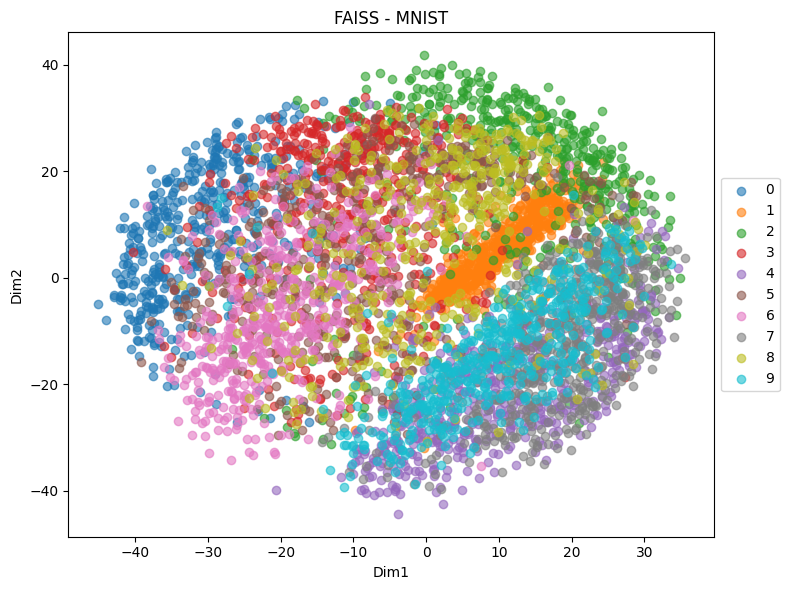

In [17]:
# Apply MDS on the geodesic distances
mds = MDS(n_components=2, dissimilarity='precomputed')
X_faiss_mds = mds.fit_transform(gcae_trainer.train_geo_dist[:5000,:5000])

# Visualise the 2d representation of the dataset
plot_2d_mnist(X_faiss_mds, y_train[:5000], 5000, unique_labels, 
               'Dim1', 'Dim2', 'FAISS - MNIST')

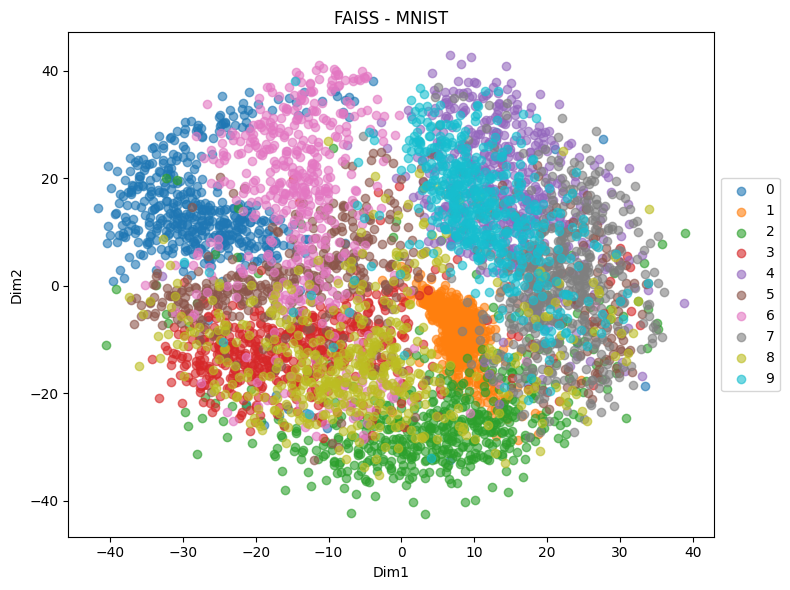

In [18]:
# Apply MDS on the geodesic distances
mds = MDS(n_components=2, dissimilarity='precomputed')
X_faiss_mds = mds.fit_transform(gcae_trainer.test_geo_dist[:5000,:5000])

# Visualise the 2d representation of the dataset
plot_2d_mnist(X_faiss_mds, y_test[:5000], 5000, unique_labels, 
               'Dim1', 'Dim2', 'FAISS - MNIST')

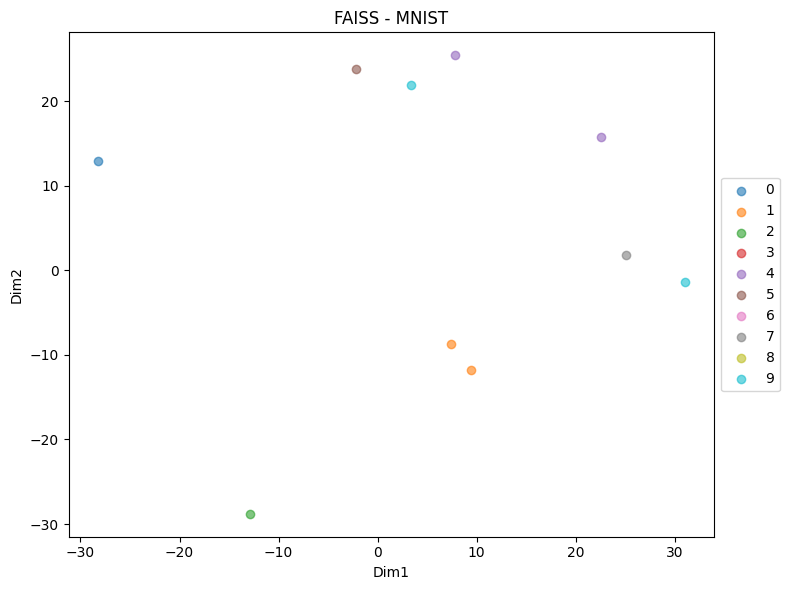

In [21]:
plot_2d_mnist(X_faiss_mds[:10], y_test[:10], 10, unique_labels, 
               'Dim1', 'Dim2', 'FAISS - MNIST')

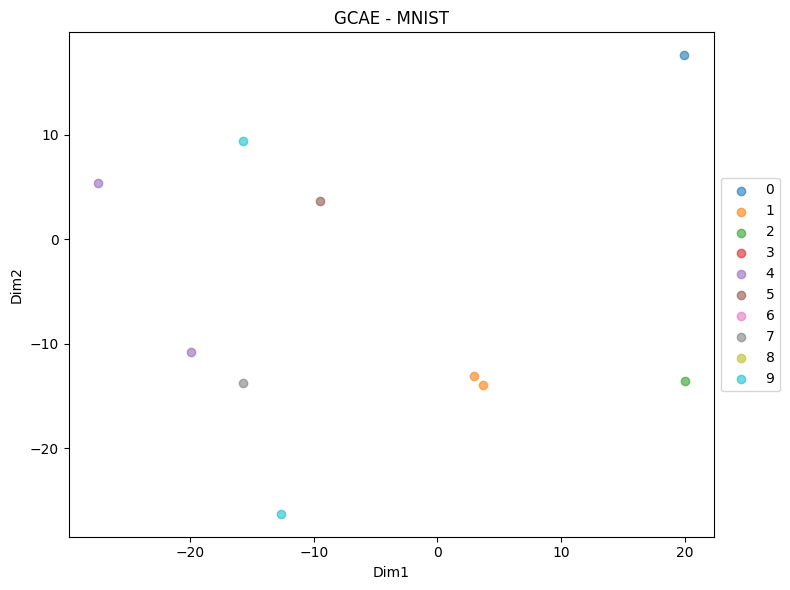

In [22]:
plot_2d_mnist(trained_encodings_gc_mnist[:10], y_test[:10], 10, unique_labels, 
               'Dim1', 'Dim2', 'GCAE - MNIST')

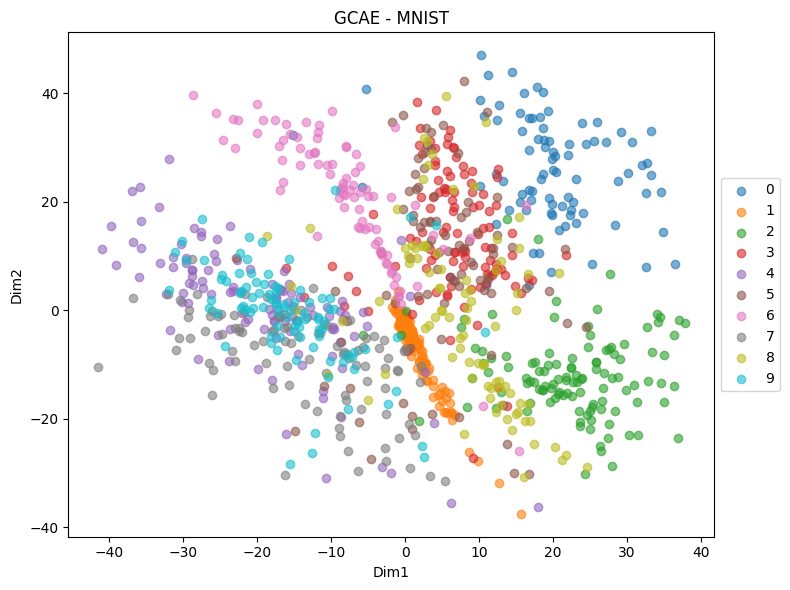

In [20]:
mnist_gc_encoder = gcae_trainer.gcae.get_layer('mnist_cnn_encoder')

# Compute the encodings after training
trained_encodings_gc_mnist = mnist_gc_encoder(x_test).numpy()

# Visualise the trained latent encodings
plot_2d_mnist(trained_encodings_gc_mnist, y_test, 1000, unique_labels, 
               'Dim1', 'Dim2', 'GCAE - MNIST')

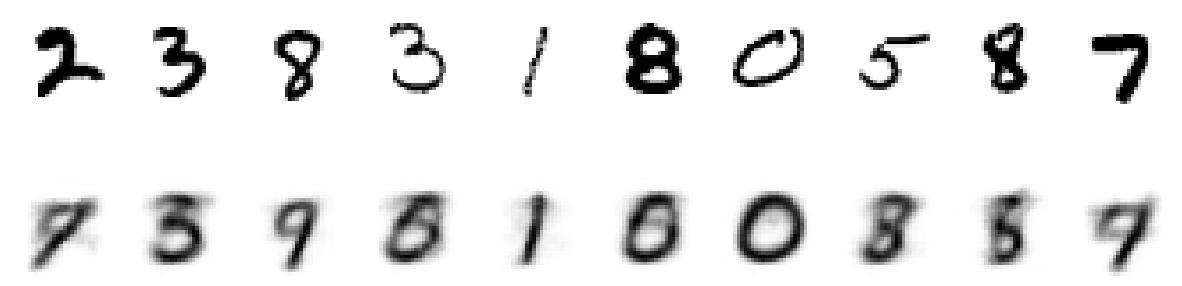

In [32]:
mnist_gc_autoencoder = gcae_trainer.gcae

np.random.seed(5)
inx = np.random.choice(x_test.shape[0], 10, replace=False)
reconstructed_mnist_images_gc = mnist_gc_autoencoder(x_test[inx])

f, axs = plt.subplots(2, 10, figsize=(15, 4))
for j in range(10):
    axs[0, j].imshow(x_test[inx][j], cmap='binary')
    axs[1, j].imshow(reconstructed_mnist_images_gc[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.show()

### Logistic Regression

In [ ]:
# Train logistic classifier using original data
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Validate accuracy using test data
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(acc)

In [ ]:
seed = 42
input_shape = (28, 28, 1)
dims = [2, 10, 20, 50, 100]
accs = []

for d in dims:
    # Build and train the CNN autoencoder for the MNIST dataset
    mnist_autoencoder = get_cnn_autoencoder(input_shape, d, 'mnist')
    mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')
    mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
    history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

    # Generate encodings for train data
    trained_mnist_encodings = mnist_encoder(x_train).numpy()

    # Train logistic classifier using standard autoencoder's embeddings
    model = LogisticRegression(random_state=seed, max_iter=1000)
    model.fit(trained_mnist_encodings, y_train)

    # Generate encodings for test data
    predicted_mnist_encodings = mnist_encoder(x_test).numpy()
    
    # Validate classification accuracy on test data
    pred = model.predict(predicted_mnist_encodings)
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print(f'Accuracy with {d} dimensions: {acc}')

In [ ]:
seed = 42
input_shape = (28, 28, 1)
dims = [2, 10, 20, 50, 100]
accs = []

for d in dims:
    # Build and train the CNN autoencoder for the MNIST dataset
    mnist_autoencoder = get_cnn_autoencoder(input_shape, d, 'mnist')
    mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')
    mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
    history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

    # Generate encodings for train data
    trained_mnist_encodings = mnist_encoder(x_train).numpy()

    # Train logistic classifier using standard autoencoder's embeddings
    model = LogisticRegression(random_state=seed, max_iter=1000)
    model.fit(trained_mnist_encodings, y_train)

    # Generate encodings for test data
    predicted_mnist_encodings = mnist_encoder(x_test).numpy()
    
    # Validate classification accuracy on test data
    pred = model.predict(predicted_mnist_encodings)
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print(f'Accuracy with {d} dimensions: {acc}')